# Long-term Memory

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langchain-chroma langchain-community

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Now that the short-term memory is ready, it's time to implement the long-term memory.

We'll use this long-term memory as a way to store external information (PDFs, articles, etc.). How? By using a Vector Database: Chroma DB.

## Indexing

<img src="https://drive.google.com/uc?id=1NgGD7Vt1-gLhlC-bMVY0vGhPyNZxamgX" alt="Alt text" width="800"/>


The first thing we'll do is to download documents from a source and index them, using ChromaDB. The first thing to do, is to instantiate the Chroma instance.

In [ ]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma


embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
llm = ChatOpenAI(model="gpt-4o-mini")


vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="longterm_memory_db",
)

Then we are going to download one of [Lilian Weng's articles](https://lilianweng.github.io/posts/2023-06-23-agent/) and apply the character splitter. This will split the document into multiple chunks.

In [ ]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

Now, we can explore the first chunk of our list.

In [ ]:
all_splits[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refin

You can easily see it belongs this chunk is located at the beginning of the full article.

<img src="https://drive.google.com/uc?id=1x3Sc_vCHeu6upyfhpOo1XdDki_L44Umo" alt="Alt text" width="800"/>

The final step, is to index the chunks!

In [ ]:
_ = vector_store.add_documents(documents=all_splits)

### Retrieval

<img src="https://drive.google.com/uc?id=15syVDH5hSHOpRZJFR2xcEweBmXNc2Wn_" alt="Alt text" width="800"/>

Now that all the chunks are indexed, we need a way to access the information stored in Chroma. Of course, we could query directly, like this:

In [ ]:
results = vector_store.similarity_search(
    "What is task decompostion?",
    k=1,
)

In [ ]:
results

[Document(id='6df989c3-9fda-4241-a88e-7c10c14ba168', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [ ]:
from langchain_core.tools.retriever import create_retriever_tool

In [ ]:
retriever = vector_store.as_retriever(search_kwargs={"k": 2})

retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_article_info_tool",
    description="Retrieve some information from Lilian Weng's article",
)

In [ ]:
retriever.invoke("What is task decomposition?")

[Document(id='6df989c3-9fda-4241-a88e-7c10c14ba168', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [ ]:
retriever_tool.invoke("What is task decomposition?")

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#\n\nCompo

Now, we need to add this retriever as a `Tool` to our graph. That's very easy if you use the `ToolNode` class.

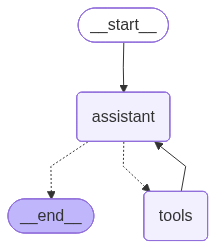

In [ ]:
from pprint import pprint
from IPython.display import Image, display


from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


llm_with_tool = llm.bind_tools([retriever_tool])

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode([retriever_tool]))

workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("tools", "assistant")

# Compile the graph
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
results = graph.invoke(
    {"messages": "What is task decomposition?"}
)

If we check the messages from the returned Graph state, we'll see some `ToolMessages` involved, which means the LLM has fetched some relevant documents from Chroma.

In [ ]:
results

{'messages': [HumanMessage(content='What is task decomposition?', additional_kwargs={}, response_metadata={}, id='a6439a07-9ff0-4b46-8d7f-12160225ed6d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_6WDLoNpsWOho33GVWYzzfs7J', 'function': {'arguments': '{"query":"task decomposition"}', 'name': 'retrieve_article_info_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CNhCzmepnWhL8j5kQlhZ96HjLD473', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--a0c29dfe-e744-4e79-876c-542b32a6bbce-0', tool_calls=[{'name': 'retrieve_article_info_tool

If you want to check the final results, just check the last `AIMessage`.

In [ ]:
print(results["messages"][-1].content)

Task decomposition involves breaking down a complex task into smaller, more manageable sub-tasks or steps. This can be accomplished through various methods:

1. **Prompting Techniques**: Using simple prompts such as "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to guide the process.

2. **Task-Specific Instructions**: Providing instructions tailored to a specific task, like "Write a story outline" for novel writing.

3. **Human Inputs**: Engaging human input to facilitate the breakdown of tasks.

An advanced approach to task decomposition is the LLM+P method, which leverages an external classical planner for long-horizon planning. This method utilizes the Planning Domain Definition Language (PDDL) as an interface to frame the planning problem. The process involves:

- Translating the problem into a "Problem PDDL".
- Using a classical planner to generate a PDDL plan informed by an existing "Domain PDDL".
- Translating the PDDL plan back into natural language.

Additional